In [1]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

# Context creation

In [2]:

conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

# Reading from S3

In [3]:
role = get_execution_role()
role

'arn:aws:iam::846033058400:role/service-role/AmazonSageMaker-ExecutionRole-20190115T085426'

# Cleaning data

In [4]:
bucket='odl-spark19spds6003-001'
data_key = 'nk4xf/heart.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
pddf = pd.read_csv(data_location)
pddf = pddf.dropna()
pddf.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Creating DF

In [5]:
df = sqlc.createDataFrame(pddf)

# Writing to parquet

In [6]:
parquetPath = './nk4xf-parquet'
# writing to local parquet store
df.write.parquet(parquetPath)

AnalysisException: 'path file:/home/ec2-user/SageMaker/nk4xf/nk4xf-parquet already exists.;'

# Writing from parquet to S3

In [ ]:
# reading files from local parquet store
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

s3 = boto3.resource('s3')
for f in files:
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "nk4xf/pqt/"+f)

# Reading from parquet into dataframe

In [7]:
df = sqlc.read.parquet(parquetPath)

In [8]:
df.head()

Row(age=63, sex=1, cp=3, trestbps=145, chol=233, fbs=1, restecg=0, thalach=150, exang=0, oldpeak=2.3, slope=0, ca=0, thal=1, target=1)

# EDA

In [9]:
df.corr('age','trestbps')

0.27935090656128797

#### Low correlation observed between age and resting blood pressure

In [10]:
df.corr('age','chol')

0.2136779565595619

#### Low correlation observed between age and chol

In [11]:
df.corr('trestbps','chol')

0.12317420653239047

#### Low correlation observed between trestbps and chol

# Feature Selection

In [12]:
df = df.select("age","sex","trestbps","chol","target")

# Test and Train split

In [13]:
seed = 7956073
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=seed)

In [14]:
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 247, test set N = 56


# Vectorization

In [15]:
from pyspark.ml.linalg import Vectors, VectorUDT

In [16]:
trainingDF.head()

Row(age=29, sex=1, trestbps=130, chol=204, target=1)

In [17]:
# Using VectorAssembler to vectorize multiple features

from pyspark.ml.feature import VectorAssembler

# defining custom function to convert input into vector
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())

featureCols = ['age','sex','trestbps','chol']



assembler = VectorAssembler(inputCols=featureCols,outputCol="features")
trainingDF = assembler.transform(trainingDF)

#### Ref - https://stackoverflow.com/questions/32556178/create-labeledpoints-from-spark-dataframe-in-python


In [18]:
trainingDF.head()

Row(age=29, sex=1, trestbps=130, chol=204, target=1, features=DenseVector([29.0, 1.0, 130.0, 204.0]))

# Renaming columns

In [19]:
#from pyspark.mllib.regression import LabeledPoint
#trainingDF = LabeledPoint(trainingDF.target, trainingDF.features)

trainingDF = trainingDF.withColumnRenamed("target", "label")

In [20]:
trainingDF = trainingDF.select('label','features')

In [21]:
#trainingDF = trainingDF.rdd.map(lambda x: LabeledPoint(x['label'],x['features']))

In [22]:
#trainingDF.take(5)

# Logistic Regression

In [23]:
from pyspark.ml.classification import LogisticRegression

logit_model = LogisticRegression().fit(trainingDF)

# Predictions

In [24]:
# Preparing test data

testDF = assembler.transform(testDF)
testDF = testDF.withColumnRenamed("target", "label")
testDF = testDF.select('label','features')

In [25]:
predictionsAndLabelsDF = logit_model.transform(testDF)

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(label=1, features=DenseVector([41.0, 1.0, 120.0, 157.0]), rawPrediction=DenseVector([-0.9697, 0.9697]), probability=DenseVector([0.2749, 0.7251]), prediction=1.0), Row(label=1, features=DenseVector([44.0, 1.0, 120.0, 226.0]), rawPrediction=DenseVector([-0.5872, 0.5872]), probability=DenseVector([0.3573, 0.6427]), prediction=1.0), Row(label=1, features=DenseVector([41.0, 1.0, 135.0, 203.0]), rawPrediction=DenseVector([-0.6927, 0.6927]), probability=DenseVector([0.3334, 0.6666]), prediction=1.0), Row(label=1, features=DenseVector([38.0, 1.0, 138.0, 175.0]), rawPrediction=DenseVector([-0.9384, 0.9384]), probability=DenseVector([0.2812, 0.7188]), prediction=1.0), Row(label=1, features=DenseVector([42.0, 1.0, 140.0, 226.0]), rawPrediction=DenseVector([-0.5122, 0.5122]), probability=DenseVector([0.3747, 0.6253]), prediction=1.0)]


# Evaluation

In [26]:


### Ref - http://spark.apache.org/docs/latest/ml-classification-regression.html

In [27]:
summary = logit_model.summary

In [28]:
type(summary.roc)

pyspark.sql.dataframe.DataFrame

In [29]:
rocDF = summary.roc.toPandas()

In [30]:
rocDF.head(5)

,FPR,TPR
0,0.0,0.000000
1,0.0,0.014815
2,0.0,0.029630
3,0.0,0.044444
4,0.0,0.059259


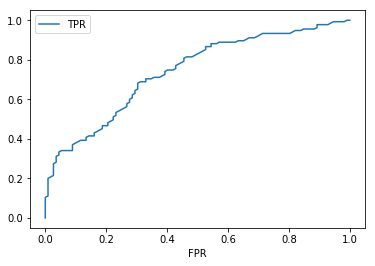

In [34]:
# Plotting ROC curve

rocDF.plot(x='FPR',y='TPR')

In [32]:
summary.areaUnderROC

0.7397817460317462

In [33]:
type(logit_model)

pyspark.ml.classification.LogisticRegressionModel